## Homework
 - Backbone, localization header, classification header 를 설계해 아래 코드가 작동될 수 있도록 구현해주세요. <br> 
 - 데이터의 크기가 변동되었음으로 해당 변동사항을 확인해주세요.
 - train ㅎ시 overfeat loss 가 최소 10 이하로 떨어져야 합니다. 
 - 수업 코드에서 제공되었던 mnist_local_generator.py 와 utils.py 을 업로드 해 사용해야 합니다. 
 

In [1]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.regularizers import l2
from mnist_local_generator import mnist_localization_generator
import matplotlib.pyplot as plt 
import numpy as np 
from utils import xywh2xyxy, draw_rectangle
import cv2
import tensorflow.keras.backend as K
import tensorflow as tf 
from tensorflow.keras.losses import CategoricalCrossentropy, MSE

In [2]:
# load mnist dataset
# Generate mnist data for localization
(train_images, train_cls_true, train_reg_true), (test_images, test_cls_true, test_reg_true) = \
    mnist_localization_generator((128, 128), (128, 128),
                                 background=True, 
                                 image_size_range=(60, 80),
                                 image_ratio_range=(0.5, 1.5),
                                 n_sample=10000)

print(train_images.shape, test_images.shape)

배경 class가 포함되어 class 는 11로 설정 되어 있습니다.


 32%|███▏      | 3174/10000 [00:00<00:00, 31425.50it/s]

train image 을 random 하게 resize 합니다.


 10%|▉         | 985/10000 [00:00<00:00, 9752.91it/s]

train image 을 random 하게 resize 합니다.


100%|██████████| 10000/10000 [00:31<00:00, 317.17it/s]


object 가 없는 background 이미지를 추가합니다.(전체 이미지의 10%)
background 의 class 는 11로 설정 되어 있습니다.
background 의 regression 는 (0,0,0,0)로 설정 되어 있습니다.


100%|██████████| 1000/1000 [00:02<00:00, 471.25it/s]


(11000, 128, 128, 1) (11000, 128, 128, 1)


In [3]:
train_true = np.concatenate([train_reg_true, train_cls_true], axis=-1)
test_true = np.concatenate([test_reg_true, test_cls_true], axis=-1)
print("train 정답길이 : {}".format(train_true.shape))
print("test 정답길이 : {}".format(test_true.shape))

train 정답길이 : (11000, 1, 1, 15)
test 정답길이 : (11000, 1, 1, 15)


In [4]:
train_reg_true = xywh2xyxy(train_reg_true)
train_reg_cls = np.concatenate([train_reg_true, train_cls_true], axis=-1)
train_cls_true.shape, train_reg_true.shape, train_reg_cls.shape
#train_reg_cls = train_reg_cls.reshape((11000,1))

((11000, 1, 1, 11), (11000, 1, 1, 4), (11000, 1, 1, 15))

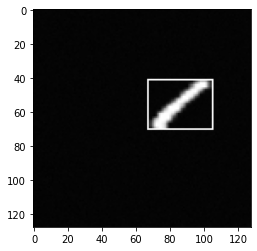

In [5]:


index = 3
sample_img = train_images[index]
sample_img = sample_img.astype('uint8')
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)
plt.imshow(sample_img)
sample_coordinate = np.squeeze(train_reg_true[index])
rected_sample_img = draw_rectangle(sample_img, sample_coordinate, (255,255,255))
plt.imshow(rected_sample_img)

## Backbone 
 - 아래 Cell Convolution 을 활용한 backbone 코드를 작성해 주세요

In [23]:
K.clear_session()
# 아래 코드에 Convolution 을 활용한 backbone 코드를 작성해 주세요

input_ = Input(shape=(128, 128, 1))
print(input_)

conv_1 = Conv2D(filters=12, kernel_size=(11, 11), strides=(4,4), padding='valid', activation='relu',
                kernel_initializer=RandomNormal(0, 0.01), kernel_regularizer=l2(0.00001))(input_)
print(conv_1.shape)
maxp_1 = MaxPool2D(pool_size=(2,2), strides=(2,2))(conv_1)
print(maxp_1.shape)

conv_2 = Conv2D(filters=32, kernel_size=(5, 5), strides=(1,1), padding='valid', activation='relu',
               kernel_initializer=RandomNormal(0,0.01), kernel_regularizer=l2(0.00001))(maxp_1)
print(conv_2.shape)
maxp_2 = MaxPool2D(pool_size=(2,2), strides=(2,2))(conv_2)
print(maxp_2.shape)
conv_3 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu',
               kernel_initializer=RandomNormal(0,0.01), kernel_regularizer=l2(0.00001))(maxp_2)
print(conv_3.shape)
conv_4 = Conv2D(filters=128, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu',
               kernel_initializer=RandomNormal(0,0.01), kernel_regularizer=l2(0.00001))(conv_3)
print(conv_4.shape)
conv_5 = Conv2D(filters=128, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu',
               kernel_initializer=RandomNormal(0,0.01), kernel_regularizer=l2(0.00001))(conv_4)
print(conv_5.shape)
maxp_5 = MaxPool2D(pool_size=(2,2), strides=(2,2))(conv_5)
print(maxp_5.shape)


KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
(None, 30, 30, 12)
(None, 15, 15, 12)
(None, 11, 11, 32)
(None, 5, 5, 32)
(None, 5, 5, 64)
(None, 5, 5, 128)
(None, 5, 5, 128)
(None, 2, 2, 128)


## Localization header
 - 아래 Cell에 Convolution 을 활용한 localization 예측 코드를 작성해 주세요

In [25]:
# 아래 코드에 Convolution 을 활용한 localization header 파트 코드를 작성해 주세요
conv_6 = Conv2D(filters=512, kernel_size=(2, 2), strides=(1,1), padding='valid', activation='relu',
               kernel_initializer=RandomNormal(0,0.01), kernel_regularizer=l2(0.00001))(maxp_5)
print(conv_6.shape)
conv_7 = Conv2D(filters=128, kernel_size=(1, 1), strides=(1,1), padding='same', activation='relu',
               kernel_initializer=RandomNormal(0,0.01), kernel_regularizer=l2(0.00001))(conv_6)
print(conv_7.shape)
loc_output = Conv2D(filters=4, kernel_size=(1, 1), strides=(1,1), padding='same', activation=None)(conv_7)
print(loc_output.shape)

(None, 1, 1, 512)
(None, 1, 1, 128)
(None, 1, 1, 4)


## Classification header
 - 아래 Cell에 Convolution 을 활용한 localization 예측 코드를 작성해 주세요

In [26]:
# 아래 코드에 Convolution 을 활용한 classification header 파트 코드를 작성해 주세요


#
conv_6 = Conv2D(filters=512, kernel_size=(2, 2), strides=(1,1), padding='valid', activation='relu',
               kernel_initializer=RandomNormal(0,0.01), kernel_regularizer=l2(0.00001))(maxp_5)
conv_7 = Conv2D(filters=128, kernel_size=(1, 1), strides=(1,1), padding='same', activation='relu',
               kernel_initializer=RandomNormal(0,0.01), kernel_regularizer=l2(0.00001))(conv_6)
cls_output = Conv2D(filters=11, kernel_size=(1, 1), strides=(1,1), padding='same', activation='softmax')(conv_7)


## Concatenate header

In [27]:
output = Concatenate(axis=-1)([loc_output, cls_output])
output

<KerasTensor: shape=(None, 1, 1, 15) dtype=float32 (created by layer 'concatenate')>

## Define overfeat loss 

In [28]:
def overfeat_mse(true, pred):
    """
    :param true: ndarray, 4d tensor (NHWC) 단 C=4
    :param pred: ndarray or tensor, 4d tensor (NHWC), 단 C=4
    :return: mse_, float,
    """

    # slicing classification and regression
    mse = MSE(true, pred)
    mse_ = tf.math.reduce_mean(mse)

    return mse_

In [29]:
def overfeat_cee(true, pred):
    """
    :param true: ndarray, 4d tensor (NHWC) 단 C=11
    :param pred: ndarray or tensor, 4d tensor (NHWC), 단 C=11
    :return: cee_, float,
    """

    cee = CategoricalCrossentropy()
    cee_ = cee(true, pred)

    return cee_ 

In [30]:
def overfeat_loss(true, pred):
    """
    Description:
    :param true: ndarray, shape = (N, 1, 1, 15=(4+11))
    :param pred: ndarray, shape = (N, 1, 1, 15=(4+11))
    """

    true_reg = true[:, :, :, :4]
    true_cls = true[:, :, :, 4:]

    pred_reg = pred[:, :, :, :4]
    pred_cls = pred[:, :, :, 4:]

    # positive 인 data의 loss 만 localization loss 에 추가 
    pos_mask = true_cls[:, :, :, -1] != 1   
    pos_true_reg = true_reg[pos_mask]
    pos_pred_reg = pred_reg[pos_mask]

    mse_loss = overfeat_mse(pos_true_reg, pos_pred_reg)
    cee_loss = overfeat_cee(true_cls, pred_cls)

    total_loss = mse_loss*0.01 + cee_loss*2
    return total_loss


In [31]:
def metric_mse(true, pred):
    """
    Description:
    :param true: ndarray, shape = (N, 1, 1, 15=(4+11))
    :param pred: ndarray, shape = (N, 1, 1, 15=(4+11))
    """

    true_reg = true[:, :, :, :4]
    true_cls = true[:, :, :, 4:]
    pred_cls = pred[:, :, :, 4:]
    pred_reg = pred[:, :, :, :4]

    # positive 인 data의 loss 만 localization loss 에 추가 
    pos_mask = true_cls[:, :, :, -1] != 1   
    pos_true_reg = true_reg[pos_mask]
    pos_pred_reg = pred_reg[pos_mask]

    mse_loss = overfeat_mse(pos_true_reg, pos_pred_reg)
    return mse_loss


In [32]:
def metric_cee(true, pred):
    """
    Description:
    :param true: ndarray, shape = (N, 1, 1, 15=(4+11))
    :param pred: ndarray, shape = (N, 1, 1, 15=(4+11))
    """
    true_cls = true[:, :, :, 4:]
    pred_cls = pred[:, :, :, 4:]
    cee_loss = overfeat_cee(true_cls, pred_cls)

    return cee_loss


## Compile model

In [33]:
# generate keras model
model = Model(input_, output)
model.compile(optimizer='adam', loss=overfeat_loss, metrics=[metric_mse, metric_cee])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 30, 30, 12)   1464        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 15, 15, 12)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 11, 11, 32)   9632        max_pooling2d[0][0]              
______________________________________________________________________________________________

## Train model

In [ ]:
sample_ys_hat = model.predict(train_images[0:1])
print("predict shape : {}".format(sample_ys_hat.shape))
sample_ys = train_true[0:1]
overfeat_loss(sample_ys, sample_ys_hat)

In [34]:
print(output.shape, train_cls_true.shape)
model.fit(train_images, train_reg_cls, batch_size=32, epochs=100)

(None, 1, 1, 15) (11000, 1, 1, 11)
Epoch 1/100
344/344 [==============================] - 13s 32ms/step - loss: 9.0404 - metric_mse: 435.9986 - metric_cee: 2.3385
Epoch 2/100
344/344 [==============================] - 11s 32ms/step - loss: 5.1649 - metric_mse: 87.7722 - metric_cee: 2.1435
Epoch 3/100
344/344 [==============================] - 11s 32ms/step - loss: 4.3258 - metric_mse: 56.8677 - metric_cee: 1.8777
Epoch 4/100
344/344 [==============================] - 11s 32ms/step - loss: 3.8240 - metric_mse: 49.6658 - metric_cee: 1.66281s - loss: 3
Epoch 5/100
344/344 [==============================] - 11s 31ms/step - loss: 3.4523 - metric_mse: 47.0142 - metric_cee: 1.4903
Epoch 6/100
344/344 [==============================] - 11s 32ms/step - loss: 3.1292 - metric_mse: 44.0444 - metric_cee: 1.3438
Epoch 7/100
344/344 [==============================] - 13s 37ms/step - loss: 2.7424 - metric_mse: 39.7959 - metric_cee: 1.1715
Epoch 8/100
344/344 [==============================] - 13s 37ms

344/344 [==============================] - 15s 43ms/step - loss: 0.2936 - metric_mse: 15.9282 - metric_cee: 0.0572
Epoch 64/100
344/344 [==============================] - 12s 36ms/step - loss: 0.2338 - metric_mse: 13.7555 - metric_cee: 0.0380
Epoch 65/100
344/344 [==============================] - 13s 39ms/step - loss: 0.2402 - metric_mse: 13.8494 - metric_cee: 0.0407
Epoch 66/100
344/344 [==============================] - 13s 38ms/step - loss: 0.3010 - metric_mse: 16.2586 - metric_cee: 0.0588
Epoch 67/100
344/344 [==============================] - 15s 43ms/step - loss: 0.2638 - metric_mse: 14.8228 - metric_cee: 0.0474
Epoch 68/100
344/344 [==============================] - 12s 35ms/step - loss: 0.2909 - metric_mse: 14.8976 - metric_cee: 0.0603
Epoch 69/100
344/344 [==============================] - 11s 33ms/step - loss: 0.2372 - metric_mse: 13.1441 - metric_cee: 0.0422
Epoch 70/100
344/344 [==============================] - 11s 33ms/step - loss: 0.2011 - metric_mse: 12.4231 - metric_c

## Predict Model

In [35]:
pred_loc_cls = model.predict(test_images[:10])

## Visualization

In [36]:
pred_loc = pred_loc_cls[:, ..., :4]
pred_cls = pred_loc_cls[:, ..., 4:]

In [37]:
pred_loc = np.squeeze(pred_loc)
pred_cls = np.argmax(pred_cls, axis=-1)
pred_cls = np.squeeze(pred_cls)

In [38]:
pred_loc = xywh2xyxy(pred_loc)

Text(0.5, 1.0, '1')

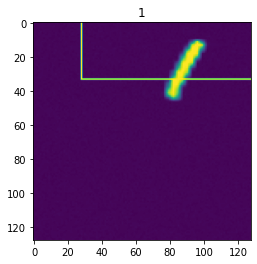

In [39]:
index = 5
rected_image = draw_rectangle(test_images[index, ..., 0], pred_loc[index])
plt.imshow(rected_image)
plt.title(pred_cls[index])

In [40]:
model.save('./best_model.h5')